# Moral dilemmas, machine learning and misconceptions

The trolley problem is a classical ethical dilemma with no simple answer. It has been features in multiple pop culture productions such as the movie The Dark Knight or the TV series The Good Place.

Here is how the story goes. Suppose you are standing next to a lever that can shift the path taken by a trolley. Initially the trolley is on a track that will lead it in the direction of five people who cannot escape the incoming thread. If you do nothing these five people will die. However, if you pull the trigger the trolley is lead to a different path and will hit and kill only one person. This begs several questions:

- Should you pull the trigger?
- Is it ethical to choose to kill one person in order to save five?
- Or the opposite, to spare the life of one person at the cost of another five.

<p align="center">
  <img src="../images/0b0584bf02449513f879837cc95f19e7e0-09-trolley.rhorizontal.w700.webp" alt="The trolley problem"/>
  <br>
  <em>The trolley problem in its classical variation. Image obtained from: https://nymag.com/intelligencer/2016/08/trolley-problem-meme-tumblr-philosophy.html</em>
</p>

Awald et al (2020) have designed an online survey where participants are asked to answer to different situations. Interestingly, alternative versions of the same problem are presented. This will be further explained ahead.


The original paper can be found here:

https://www.pnas.org/doi/10.1073/pnas.1911517117

The authors have made the data available on:

https://osf.io/mxa6z/?view_only=33719a32d86a4ec186a21287a233040c

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_curve


In [2]:
plt.style.use("ggplot")

## 1 - Data acquisition

In [3]:
df_shared_data_demographics_raw = pd.read_csv("../data/Shared_data_responses_demographics.csv")

In [4]:
df_shared_data_demographics_raw.head(2)

,UserIP_Anonymized,Scenario,survey.age,survey.gender,survey.education,survey.political,survey.religious,country_code,Outcome,Continent
0,0002ae2d,Footbridge,19,Women,College,0.56,0.0,GB,0,Europe
1,0002ae2d,Loop,19,Women,College,0.56,0.0,GB,1,Europe


The dataframe we will use for the analysis is df_shared_data_demographics, it shows the results for the survey. Each line corresponds to a participant response, three possible situations were presented ("Scenario" column) for each possible intervention a person could do:

<p align="center">
  <img src="../images/switch-loop-footbridge-2.jpg" alt="Possible scenarios"/>
  <br>
  <em> The three scenarios for the trolley problem. Obatined from Awald et al. (2020) </em>
</p>

From the image above we can discuss the three situations presented in the survey:

*Switch*: in this first version, the intervention of the participant shifts the path of the trolley leading it to kill only one person instead of five

*Loop*: now, the situation becomes a little more complicated, in order to save the five workers, the trolley must be lead to a path with only one person. The impact will lead the trolley to stop.

*Footbridge*: now, once again the option involves the impact of the trolley with a person who is standing on the bride. He is a big person, and the shock will be enough to stop the menace from killing the five people. But now there is no lever available, it is necessary to personally push the person, which involves physical contact.

Additional information are presented to each participant:
- age on "survey.age",
- gender on "survey.gender"
- education on "survey.education"
- political on "survey.political", ranging from 0 to 1, corresponding to conservative to progressive
- religious views on "survey.religious", ranging from 0 to 1, corresponding to non-religious to religious
- country code on "country_code"
- continent on "Continent"
- Outcome on "outcome": this column indicates the action chosen by the participant, 0 if the person would not intervene and 1 otherwise
- "UserIP_Anonymized" is an individual ID for each person

Based on this data we can study the characteristics of each group. Following, we can try and answer: based on a give set of attributes (age, gender...) will the person intervene or not.

In [5]:
df_shared_data_demographics_raw.describe()

,survey.age,survey.political,survey.religious,Outcome
count,59159.000000,59159.000000,59159.000000,59159.000000
mean,28.067834,0.628667,0.243850,0.688889
std,10.213054,0.263498,0.302178,0.462952
min,18.000000,0.000000,0.000000,0.000000
25%,21.000000,0.500000,0.000000,0.000000
50%,25.000000,0.620000,0.070000,1.000000
75%,32.000000,0.840000,0.500000,1.000000
max,89.000000,1.000000,1.000000,1.000000


## 2 - Data cleaning

### 2.1 - Missing data

<AxesSubplot:>

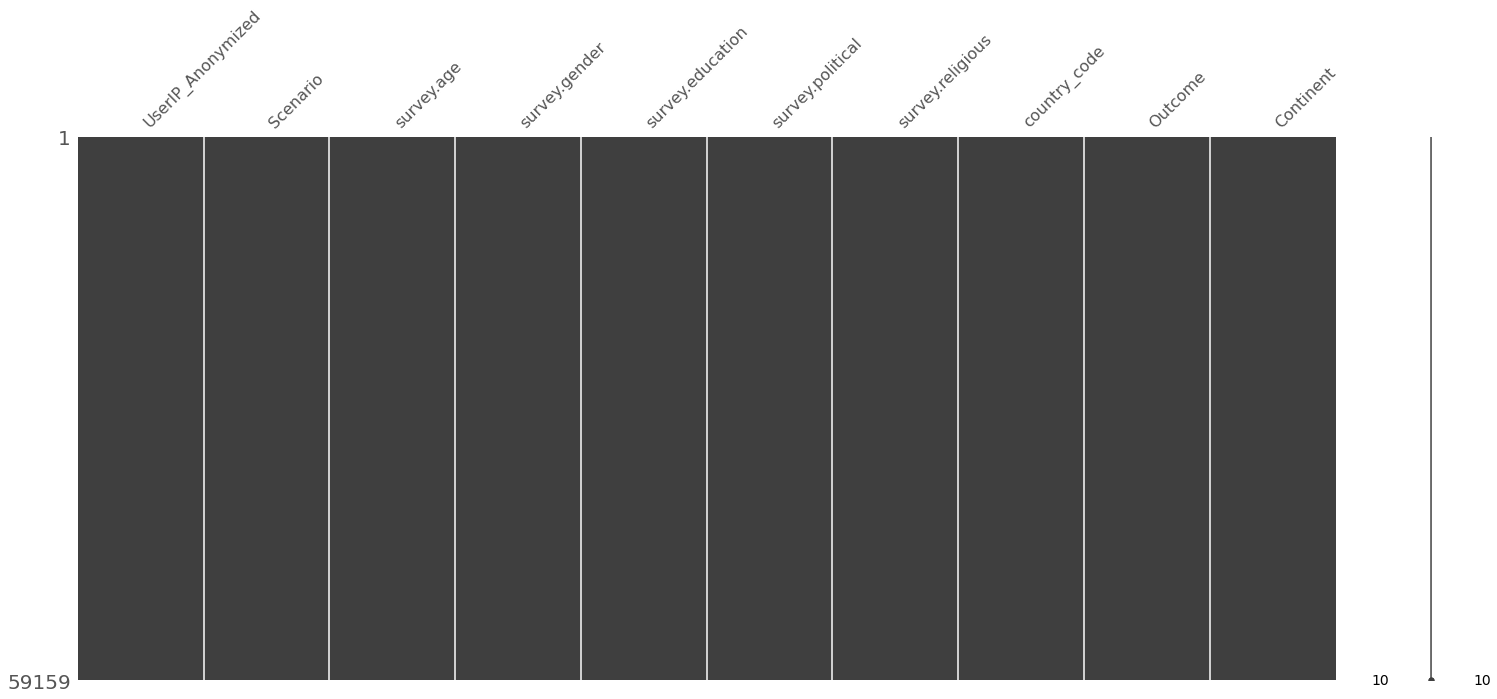

In [6]:
missingno.matrix(df_shared_data_demographics_raw, sort="ascending")

Both dataframes present no missing data, from the previous visualizations all columns are complete for both objects.

### 2.2 - Basic cleaning and column selection

In [7]:
df_shared_data_demographics_clean = (
    df_shared_data_demographics_raw
    .rename(columns={
        "UserIP_Anonymized":"id",
        "Scenario":"scenario",
        "survey.age":"age",
        "survey.gender":"gender",
        "survey.education":"education",
        "survey.political":"political",
        "survey.religious":"religious",
        "country_code":"country",
        "Outcome":"outcome",
        "Continent":"continent"
    })
)

## 3 - Data visualization

### 3.1 - Age pyramid

In [8]:
df_age_pyramid = (
    df_shared_data_demographics_clean
    .assign(
        age_range = lambda df: pd.cut(df["age"], bins=np.arange(0, 101, 5), right=False, labels=[f"{i}-{i+5}" for i in np.arange(0, 96, 5)])
    )
    .groupby(["age_range", "gender", "scenario", "outcome"])
    .agg(
        number_people=("id", "nunique")
    )
    .reset_index()
)

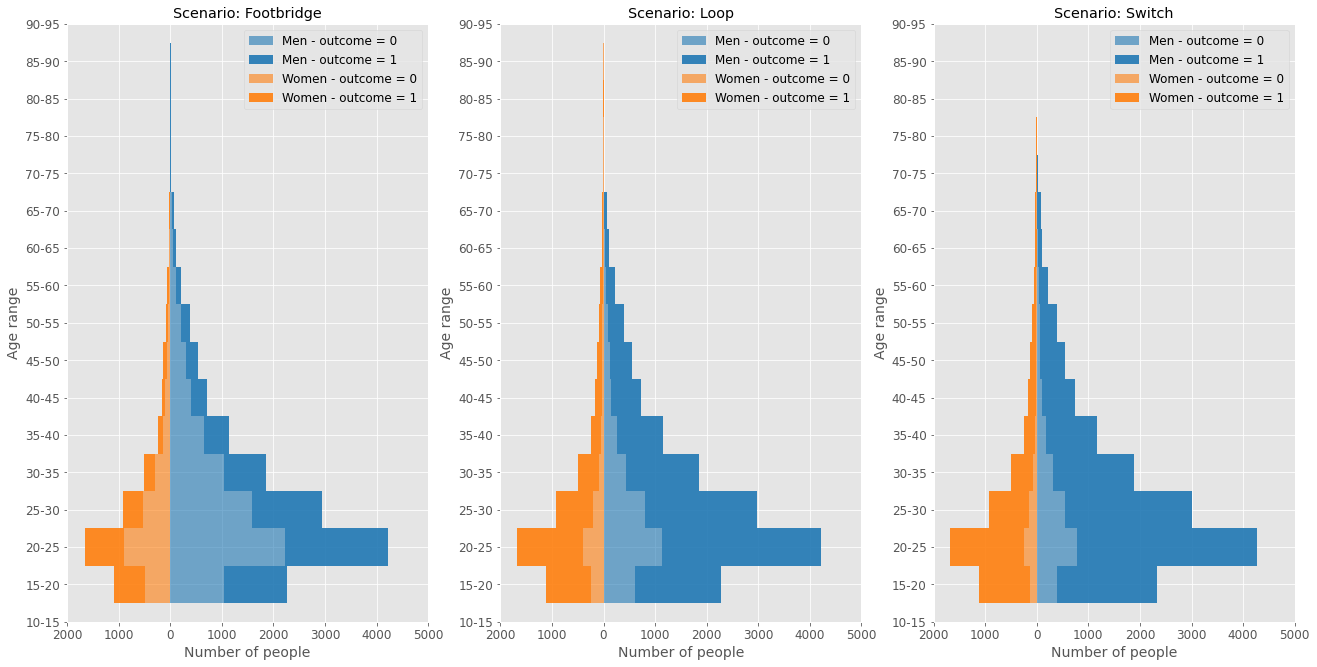

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
y_aux = np.arange(0, df_age_pyramid["age_range"].nunique())

for i, scenario in enumerate(df_age_pyramid["scenario"].unique()):
    aux_data = df_age_pyramid.query(f"scenario == '{scenario}'").drop(columns="scenario")

    ax[i].barh(
        y=y_aux,
        width=aux_data.query("gender == 'Men' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Men - outcome = 0",
        color=plt.cm.tab10.colors[0],
        alpha=0.6
    )

    ax[i].barh(
        y=y_aux,
        width=aux_data.query("gender == 'Men' & outcome == 1")["number_people"],
        left=aux_data.query("gender == 'Men' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Men - outcome = 1",
        color=plt.cm.tab10.colors[0],
        alpha=0.9
    )

    ax[i].barh(
        y=y_aux,
        width=-aux_data.query("gender == 'Women' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Women - outcome = 0",
        color=plt.cm.tab10.colors[1],
        alpha=0.6
    )

    ax[i].barh(
        y=y_aux,
        width=-aux_data.query("gender == 'Women' & outcome == 1")["number_people"],
        left=-aux_data.query("gender == 'Women' & outcome == 0")["number_people"],
        height=1,
        align="center",
        label="Women - outcome = 1",
        color=plt.cm.tab10.colors[1],
        alpha=0.9
    )

    ax[i].legend(fontsize=12)
    ax[i].set_xticks(np.arange(-2000, 5001, 1000))
    ax[i].set_xticklabels(np.abs(np.arange(-2000, 5001, 1000)), fontsize=12)
    ax[i].set_yticks(y_aux)
    ax[i].set_yticklabels(df_age_pyramid["age_range"].unique(), fontsize=12)
    ax[i].set_ylim(2, 18)
    ax[i].set_xlabel("Number of people", fontsize=14)
    ax[i].set_ylabel("Age range", fontsize=14)
    ax[i].set_title(f"Scenario: {scenario}")

Above it is possible to see the age pyramid clustered for the three scenarios. The lighter colors indicate the participant didn't take the action, while the darker one indicates he/she did take the action. It is noticeable that interventions are more common for the Switch, and very less frequent for the Footbridge given the same gender and age range.

The diversity of the participants is also unbalanced, there are more men than women in the survey. Additionally, the participants tend to be young adults.

Following, let's investigate if the responses are statistically associated with gender and age.

### 3.2 - Age and gender statistical tests

In [10]:
df_age_per_group = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        age_list=("age", list)
    )
    .reset_index()
)

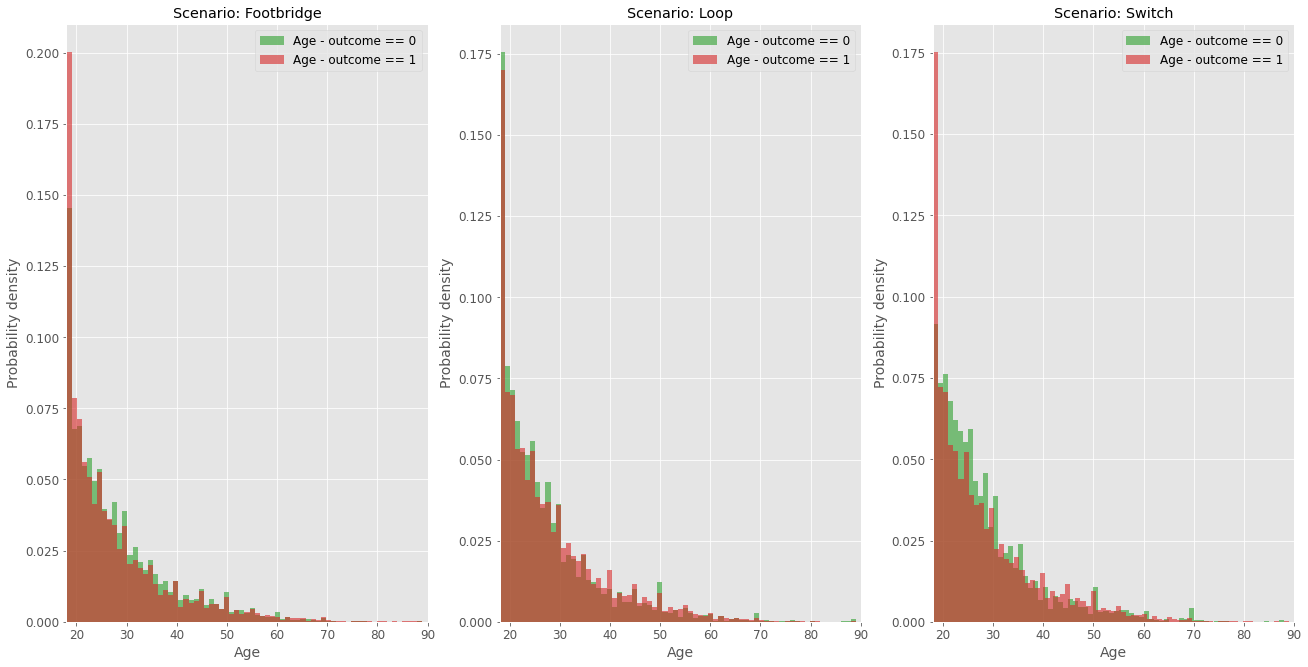

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))

BINS = 70

for i, scenario in enumerate(df_age_per_group["scenario"].unique()):
    y_0, x_0, _ = ax[i].hist(
        df_age_per_group.query(f"scenario == '{scenario}' & outcome == 0")["age_list"],
        bins=BINS,
        color=plt.cm.tab10.colors[2],
        alpha=0.6,
        density=True,
        label="Age - outcome == 0"
    )

    y_1, x_1, _ = ax[i].hist(
        df_age_per_group.query(f"scenario == '{scenario}' & outcome == 1")["age_list"],
        bins=BINS,
        color=plt.cm.tab10.colors[3],
        alpha=0.6,
        density=True,
        label="Age - outcome == 1"
    )

    ax[i].set_xlabel("Age", fontsize=14)
    ax[i].set_ylabel("Probability density", fontsize=14)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlim(18, 90)
    ax[i].legend(fontsize=12);

From the age distribution shown above, the population is very centered around 20 year, and the data does not seem to follow a normal-like distribution as it typically happens with population analysis. In this case, the data seems to have an exponential-like behavior.

In [12]:
df_gender_scenario = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "gender", "outcome"])
    .agg(
        number_people=("id", "nunique")
    )
    .reset_index()
    .assign(
        total_scenario = lambda df: df.groupby(["scenario", "outcome"])["number_people"].transform(lambda x: x.sum()),
        lower_bound = lambda df: 100*proportion_confint(df["number_people"], df["total_scenario"])[0],
        upper_bound = lambda df: 100*proportion_confint(df["number_people"], df["total_scenario"])[1],
        relative_frequency = lambda df: 100*df["number_people"]/df["total_scenario"],
        interval = lambda df: df["upper_bound"] - df["lower_bound"]
    )
)

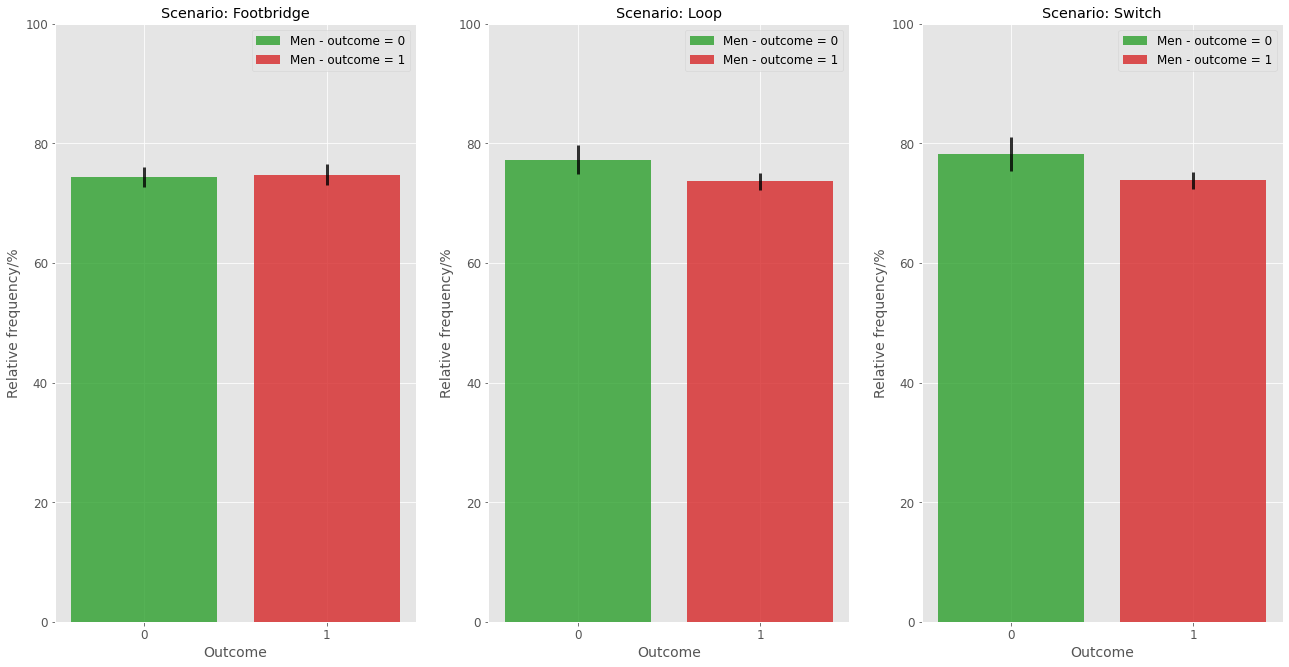

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))

for i, scenario in enumerate(df_gender_scenario["scenario"].unique()):
    ax[i].bar(
        [0],
        df_gender_scenario.query(f"gender == 'Men' & outcome == 0 & scenario == '{scenario}'")["relative_frequency"],
        color=plt.cm.tab10.colors[2],
        alpha=0.8,
        label="Men - outcome = 0"
    )

    ax[i].errorbar(
        [0],
        y=df_gender_scenario.query(f"gender == 'Men' & outcome == 0 & scenario == '{scenario}'")["relative_frequency"],
        yerr=df_gender_scenario.query(f"gender == 'Men' & outcome == 0 & scenario == '{scenario}'")["interval"],
        elinewidth=3,
        ecolor="k",
        alpha=0.8
    )

    ax[i].bar(
        [1],
        df_gender_scenario.query(f"gender == 'Men' & outcome == 1 & scenario == '{scenario}'")["relative_frequency"],
        color=plt.cm.tab10.colors[3],
        alpha=0.8,
        label="Men - outcome = 1"
    )

    ax[i].errorbar(
        [1],
        y=df_gender_scenario.query(f"gender == 'Men' & outcome == 1 & scenario == '{scenario}'")["relative_frequency"],
        yerr=df_gender_scenario.query(f"gender == 'Men' & outcome == 1 & scenario == '{scenario}'")["interval"],
        elinewidth=3,
        ecolor="k",
        alpha=0.8
    )

    ax[i].set_ylim(0, 100)
    ax[i].set_xticks(np.arange(0, 2))
    ax[i].set_xlabel("Outcome", fontsize=14)
    ax[i].set_ylabel("Relative frequency/%", fontsize=14)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend(fontsize=12);

The graph above displays the relative frequency for Men grouped by each outcome in each scenario. One can notice that for the Footbridge case, there seems to be no significant difference between the frequencies of men at each outcome. However, for the other two scenarios, men seem to be less prone to take an action.

### 3.3 - Political views

In [14]:
df_politics_scenario = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        political=("political", list)
    )
    .reset_index()
)

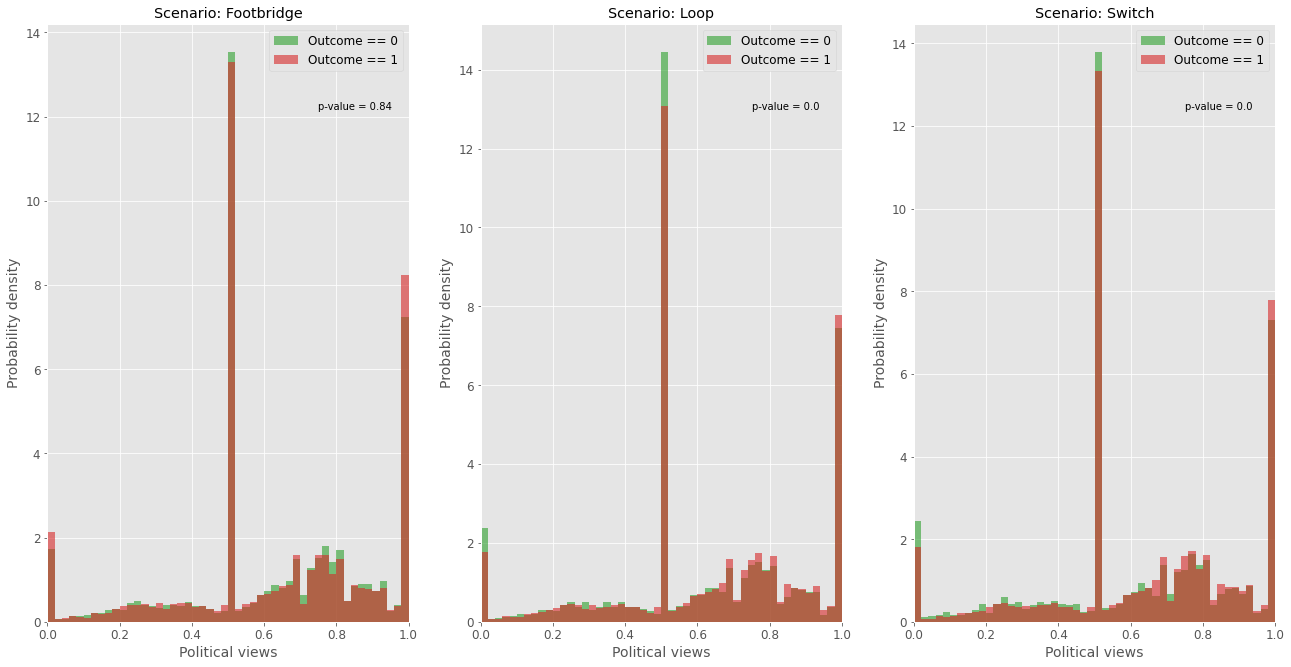

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
BINS = 50
for i, scenario in enumerate(df_politics_scenario["scenario"].unique()):
    y0, x0, _ = ax[i].hist(
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 0")["political"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[2],
        alpha=0.6,
        label="Outcome == 0"
    )

    y1, x1, _ = ax[i].hist(
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 1")["political"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[3],
        alpha=0.6,
        label="Outcome == 1"
    )

    _, p_value = ttest_ind(
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 0")["political"].values[0],
        df_politics_scenario.query(f"scenario == '{scenario}' & outcome == 1")["political"].values[0],
    )

    ax[i].annotate(
        f"p-value = {np.round(p_value, 2)}",
        xy=(0.75*np.max([x0, x1]), 0.9*np.max([y0, y1]))
    )

    ax[i].set_xlabel("Political views", fontsize=14)
    ax[i].set_ylabel("Probability density", fontsize=14)
    ax[i].set_xlim(0, 1)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].legend(fontsize=12)

In [16]:
(
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        political_views=("political", "mean")
    )
    .reset_index()
    .pivot(
        index="scenario",
        columns="outcome",
        values="political_views"
    )
)

outcome,0,1
scenario,,
Footbridge,0.629286,0.628529
Loop,0.611545,0.633625
Switch,0.608016,0.632802


The previous histogram shows the dispersion of the political views under each scenario and separated by outcomes. For the footbridge situation, the difference in means is not statistically significant. However, for other cases, the group of people how opt for a positive action (outcome = 1) seems to be more aligned with progressive views as the p-values indicated in the plot indicates alongside the previous table.

### 3.4 - Religious views

In [17]:
df_religious_scenario = (
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        religious=("religious", list)
    )
    .reset_index()
)

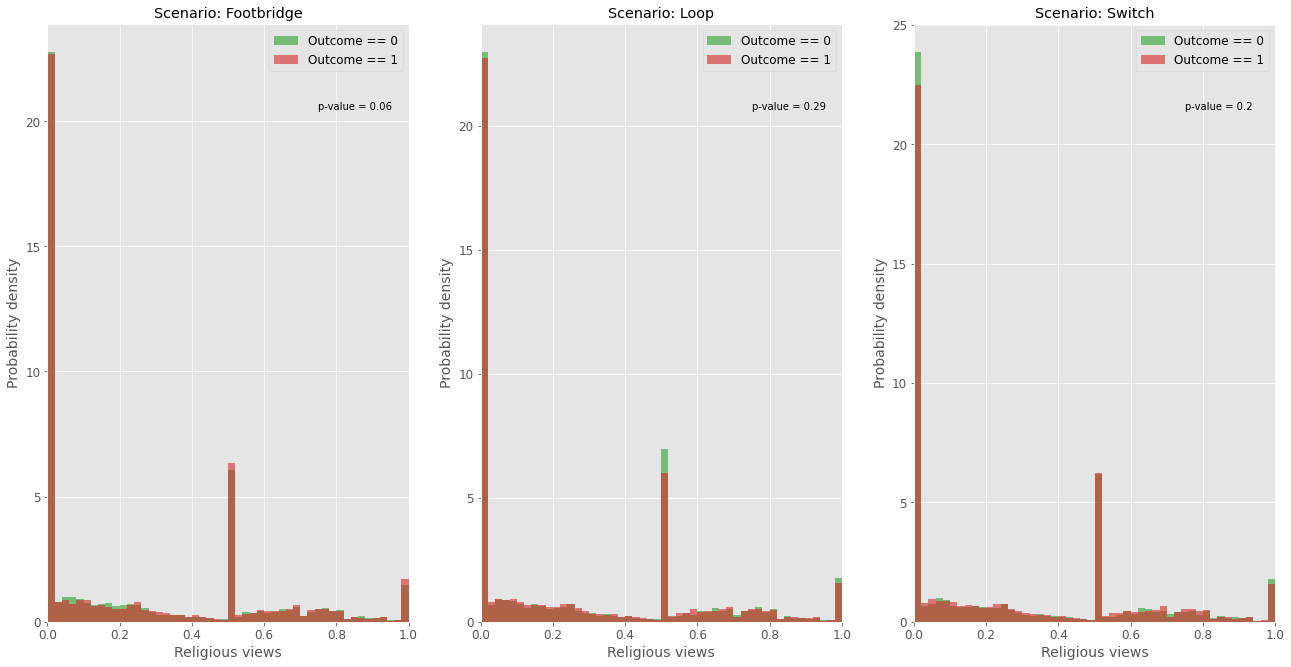

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
BINS = 50
for i, scenario in enumerate(df_religious_scenario["scenario"].unique()):
    y0, x0, _ = ax[i].hist(
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 0")["religious"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[2],
        alpha=0.6,
        label="Outcome == 0"
    )

    y1, x1, _ = ax[i].hist(
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 1")["religious"],
        bins=BINS,
        density=True,
        color=plt.cm.tab10.colors[3],
        alpha=0.6,
        label="Outcome == 1"
    )

    _, p_value = ttest_ind(
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 0")["religious"].values[0],
        df_religious_scenario.query(f"scenario == '{scenario}' & outcome == 1")["religious"].values[0],
    )

    ax[i].annotate(
        f"p-value = {np.round(p_value, 2)}",
        xy=(0.75*np.max([x0, x1]), 0.9*np.max([y0, y1]))
    )

    ax[i].set_xlabel("Religious views", fontsize=14)
    ax[i].set_ylabel("Probability density", fontsize=14)
    ax[i].set_xlim(0, 1)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].legend(fontsize=12)

In [19]:
(
    df_shared_data_demographics_clean
    .groupby(["scenario", "outcome"])
    .agg(
        religous_views=("religious", "mean")
    )
    .reset_index()
    .pivot(
        index="scenario",
        columns="outcome",
        values="religous_views"
    )
)

outcome,0,1
scenario,,
Footbridge,0.239746,0.248050
Loop,0.247548,0.242242
Switch,0.238063,0.245603


Interestingly, in the case of religion, there seems to be no statistically significant difference between the views of people who don't take the action (outcome == 0) and those who take (outcome == 1). The most critical case occurs for the footbridge scenario, as the p-value calculated through t-test is relatively small (0.06). In this case, the people who take the action are on average more religious than those who do not take it.

### 3.5 - Education

In [20]:
df_education_scenario = (
    df_shared_data_demographics_clean
    .groupby(["education", "scenario", "outcome"])
    .agg(
        number_people = ("id", "nunique")
    )
    .reset_index()
    .assign(
        total_scenario = lambda df: (
            df.groupby(["scenario", "outcome"])
            ["number_people"].transform(
                lambda x: x.sum()
            )
        ),
        lower_bound = lambda df: 100*proportion_confint(
            df["number_people"],
            df["total_scenario"]
        )[0],
        upper_bound = lambda df: 100*proportion_confint(
            df["number_people"],
            df["total_scenario"]
        )[1],
        relative_frequency = lambda df: (
            100*df["number_people"]
            /df["total_scenario"]
        ),
        interval = lambda df: df["upper_bound"] - df["lower_bound"]
    )
)

In [21]:
df_education_scenario.tail()

,education,scenario,outcome,number_people,total_scenario,lower_bound,upper_bound,relative_frequency,interval
7,No College,Footbridge,1,2826,9028,30.346053,32.259175,31.302614,1.913122
8,No College,Loop,0,1271,4736,25.575006,28.098980,26.836993,2.523974
9,No College,Loop,1,4021,14681,26.667769,28.110516,27.389142,1.442747
10,No College,Switch,0,791,3199,23.231470,26.221484,24.726477,2.990014
11,No College,Switch,1,4588,16438,27.225220,28.596656,27.910938,1.371436


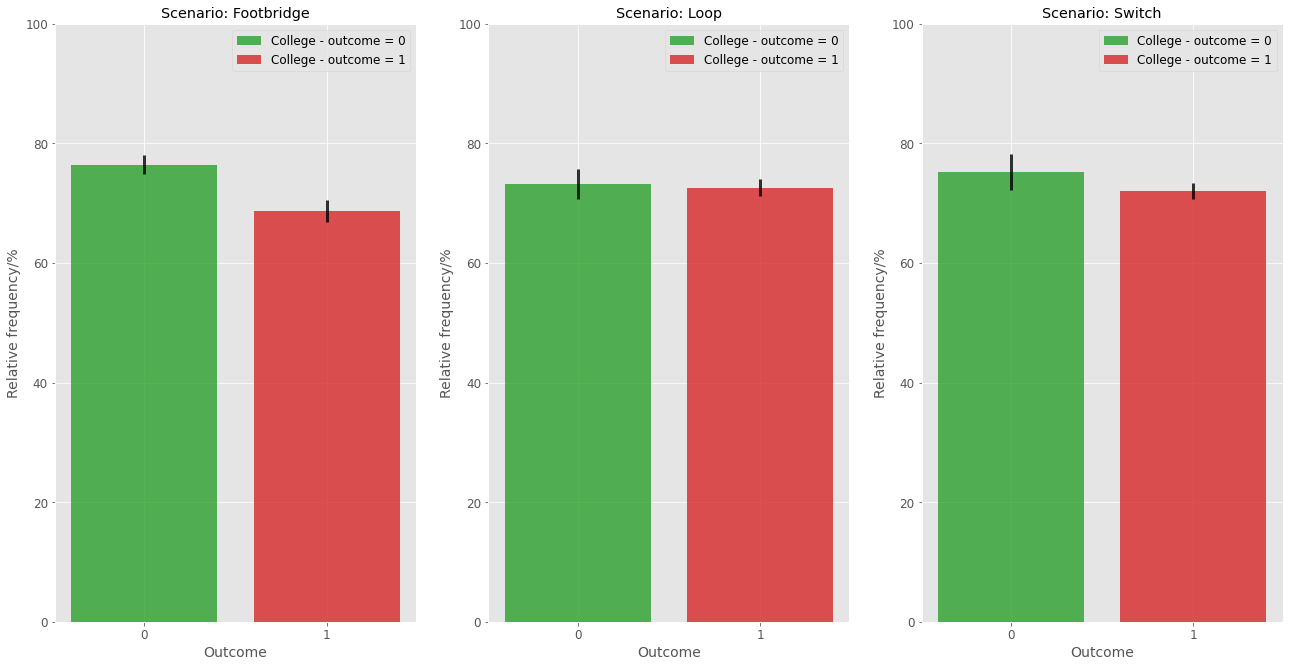

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,11))

for i, scenario in enumerate(df_education_scenario["scenario"].unique()):
    ax[i].bar(
        [0],
        df_education_scenario.query(f"education == 'College' & outcome == 0 & scenario == '{scenario}'")["relative_frequency"],
        color=plt.cm.tab10.colors[2],
        alpha=0.8,
        label="College - outcome = 0"
    )

    ax[i].errorbar(
        [0],
        y=df_education_scenario.query(f"education == 'College' & outcome == 0 & scenario == '{scenario}'")["relative_frequency"],
        yerr=df_education_scenario.query(f"education == 'College' & outcome == 0 & scenario == '{scenario}'")["interval"],
        elinewidth=3,
        ecolor="k",
        alpha=0.8
    )

    ax[i].bar(
        [1],
        df_education_scenario.query(f"education == 'College' & outcome == 1 & scenario == '{scenario}'")["relative_frequency"],
        color=plt.cm.tab10.colors[3],
        alpha=0.8,
        label="College - outcome = 1"
    )

    ax[i].errorbar(
        [1],
        y=df_education_scenario.query(f"education == 'College' & outcome == 1 & scenario == '{scenario}'")["relative_frequency"],
        yerr=df_education_scenario.query(f"education == 'College' & outcome == 1 & scenario == '{scenario}'")["interval"],
        elinewidth=3,
        ecolor="k",
        alpha=0.8
    )

    ax[i].set_ylim(0, 100)
    ax[i].set_xticks(np.arange(0, 2))
    ax[i].set_xlabel("Outcome", fontsize=14)
    ax[i].set_ylabel("Relative frequency/%", fontsize=14)
    ax[i].set_title(f"Scenario: {scenario}")
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend(fontsize=12);

Analyzing the education distribution among the participants, one can notice that there seems to be no significant difference between the relative frequencies of college-educated people and non-college educated people for the Loop and Switch scenarios. However, for the footbridge case, the frequency of college educated people seems a bit smaller among those who take the action.

### 3.6 Regions

In [23]:
df_shared_data_demographics_clean.head(2)

,id,scenario,age,gender,education,political,religious,country,outcome,continent
0,0002ae2d,Footbridge,19,Women,College,0.56,0.0,GB,0,Europe
1,0002ae2d,Loop,19,Women,College,0.56,0.0,GB,1,Europe


In [24]:
df_country_scenario = (
    df_shared_data_demographics_clean
    .groupby(["country", "id"])
    .agg(
        take_any_action = ("outcome", "max")
    )
    .reset_index()
    .groupby("country")
    .agg(
        take_any_action = ("take_any_action", "sum"),
        number_people = ("id", "nunique")
    )
    .reset_index()
    .assign(
        relative_frequency = lambda df: (
            100*df["take_any_action"]
            /df["number_people"]
        ),
        lower_bound = lambda df: 100*proportion_confint(
            df["take_any_action"],
            df["number_people"]
        )[0],
        upper_bound = lambda df: 100*proportion_confint(
            df["take_any_action"],
            df["number_people"]
        )[1],
        interval = lambda df: (
            df["upper_bound"] - df["lower_bound"]
        )
    )
    .sort_values("relative_frequency", ascending=False)
    .reset_index()
)

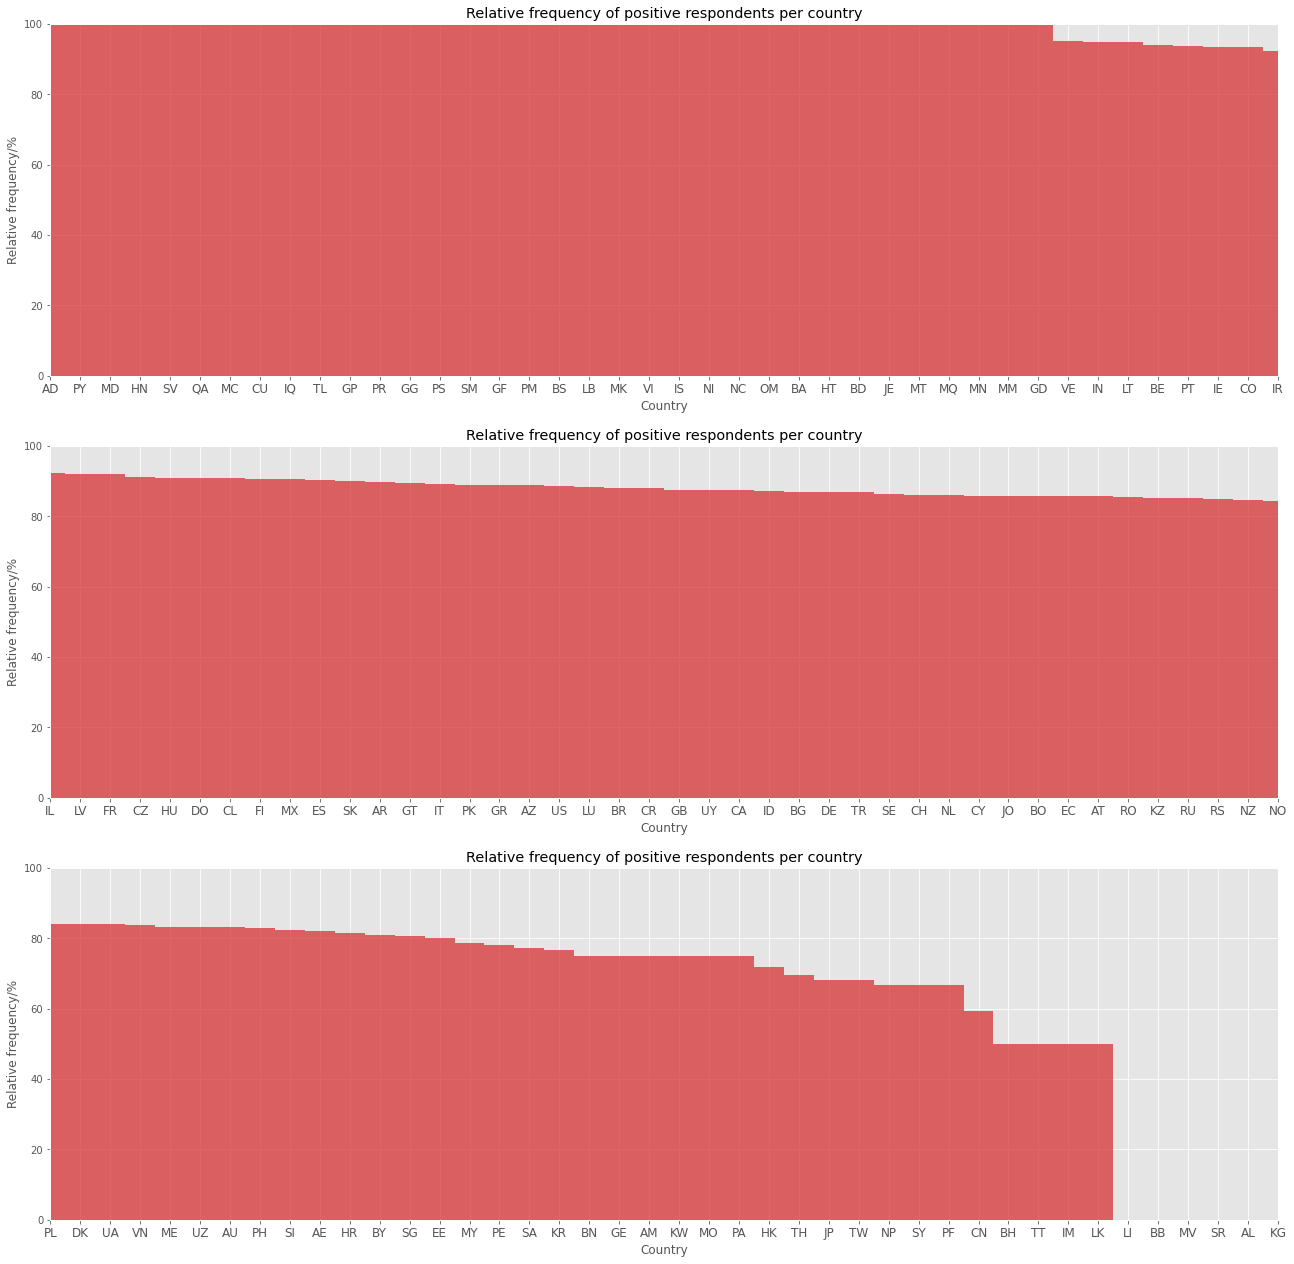

In [25]:
BLOCKS = 3

fig, ax = plt.subplots(nrows=BLOCKS, ncols=1, figsize=(22,22))

for i, data in enumerate(np.array_split(df_country_scenario, BLOCKS)):

    ax[i].bar(
        x=data.index,
        height=data["relative_frequency"],
        width=1,
        align="center",
        color=plt.cm.tab10.colors[3],
        alpha=0.7
    )
    ax[i].set_ylim(0, 100)
    ax[i].set_xlim(
        np.min(data.index),
        np.max(data.index)
    )
    ax[i].set_xticks(data.index)
    ax[i].set_xticklabels(data["country"], fontsize=12)
    ax[i].set_xlabel("Country")
    ax[i].set_ylabel("Relative frequency/%")
    ax[i].set_title("Relative frequency of positive respondents per country");

Above, the frequency of positive respondents per country is presented. Here positive respondent is defined as someone who gave a positive answer for at least one of the three scenarios. Unfortunately, some countries have a very small sample of participants, as a result, the calculated frequency is not significant. So, it should be more interesting to investigate the result per continent.

### 3.7 - Continent

In [26]:
df_continent_scenario = (
    df_shared_data_demographics_clean
    .groupby(["continent", "id"])
    .agg(
        take_any_action = ("outcome", "max")
    )
    .reset_index()
    .groupby("continent")
    .agg(
        take_any_action = ("take_any_action", "sum"),
        number_people = ("id", "nunique")
    )
    .reset_index()
    .assign(
        relative_frequency = lambda df: (
            100*df["take_any_action"]
            /df["number_people"]
        ),
        lower_bound = lambda df: 100*proportion_confint(
            df["take_any_action"],
            df["number_people"]
        )[0],
        upper_bound = lambda df: 100*proportion_confint(
            df["take_any_action"],
            df["number_people"]
        )[1],
        interval = lambda df: (
            df["upper_bound"] - df["lower_bound"]
        )
    )
    .sort_values("relative_frequency", ascending=False)
    .reset_index()
)

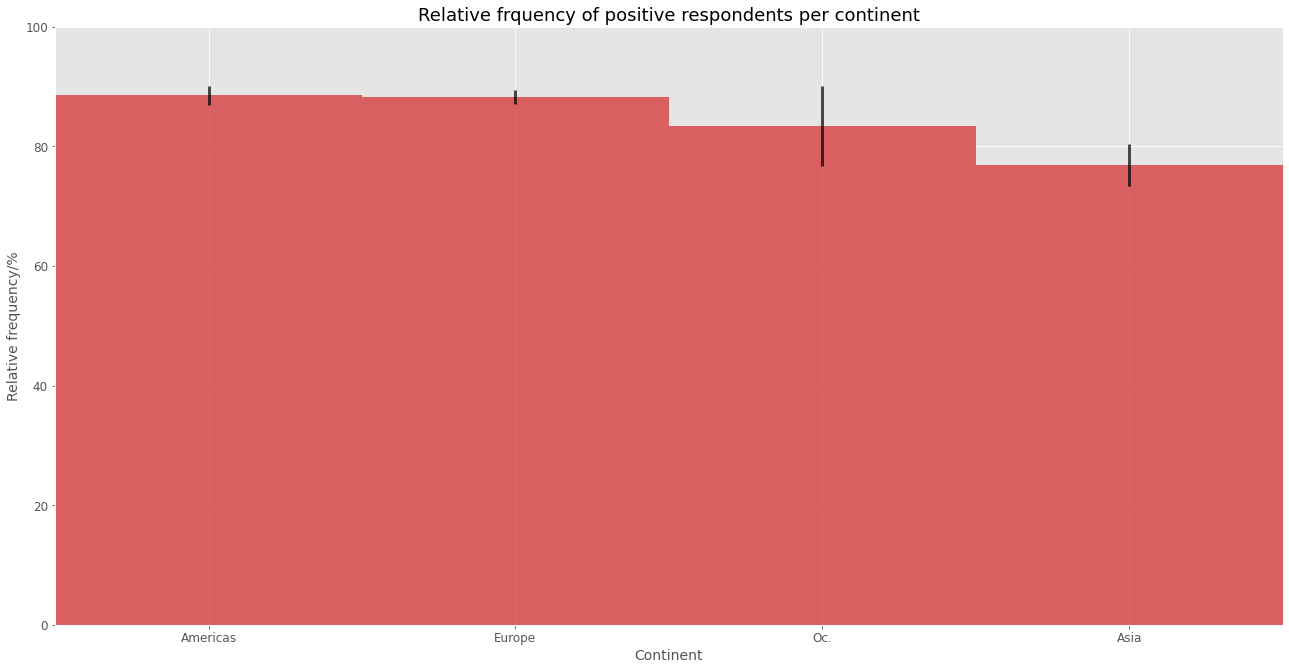

In [27]:
fig, ax = plt.subplots(figsize=(22,11))

ax.bar(
    x=df_continent_scenario.index,
    height=df_continent_scenario["relative_frequency"],
    width=1,
    align="center",
    color=plt.cm.tab10.colors[3],
    alpha=0.7
)

ax.errorbar(
    x=df_continent_scenario.index,
    y=df_continent_scenario["relative_frequency"],
    yerr=df_continent_scenario["interval"],
    ecolor="k",
    elinewidth=3,
    alpha=0.7,
    ls=""
)

ax.set_xlim(
    np.min(df_continent_scenario.index)-0.5,
    np.max(df_continent_scenario.index)+0.5
)

ax.set_xticks(df_continent_scenario.index)
ax.set_xticklabels(df_continent_scenario["continent"])
ax.set_ylim(0, 100)
ax.set_xlabel("Continent", fontsize=14)
ax.set_ylabel("Relative frequency/%", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title("Relative frquency of positive respondents per continent", fontsize=18);

The analysis per continent exists very similar frequency of positive respondents per continent, while the biggest differences are between the Americas and Europe and Asia

## 4 - Modelling

### 4.1 - Data preprocessing

In [28]:
df_modelling = (
    pd.get_dummies(
        df_shared_data_demographics_clean, columns=["continent", "country", "scenario"]
    )
    .drop(columns=["id"])
    .assign(
        gender = lambda df: df["gender"].replace({
            "Women":0,
            "Men":1
        }),
        education = lambda df: df["education"].replace({
            "College":1,
            "No College":0
        })
    )
)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df_modelling.drop(columns="outcome"),
    df_modelling["outcome"],
    test_size=0.25,
    stratify=df_modelling["outcome"],
    random_state=42
)

In [30]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.2 - Model fitting

#### 4.2.1 - Logistic regression

In [31]:
logistic_regression_param_grid = {
    "C":np.logspace(-6,-3, 10)
}

logistic_regression_grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=logistic_regression_param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

logistic_regression_grid_search.fit(
    X_train_scaled,
    y_train
)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-06, 2.15443469e-06, 4.64158883e-06, 1.00000000e-05,
       2.15443469e-05, 4.64158883e-05, 1.00000000e-04, 2.15443469e-04,
       4.64158883e-04, 1.00000000e-03])},
             return_train_score=True, scoring='roc_auc')

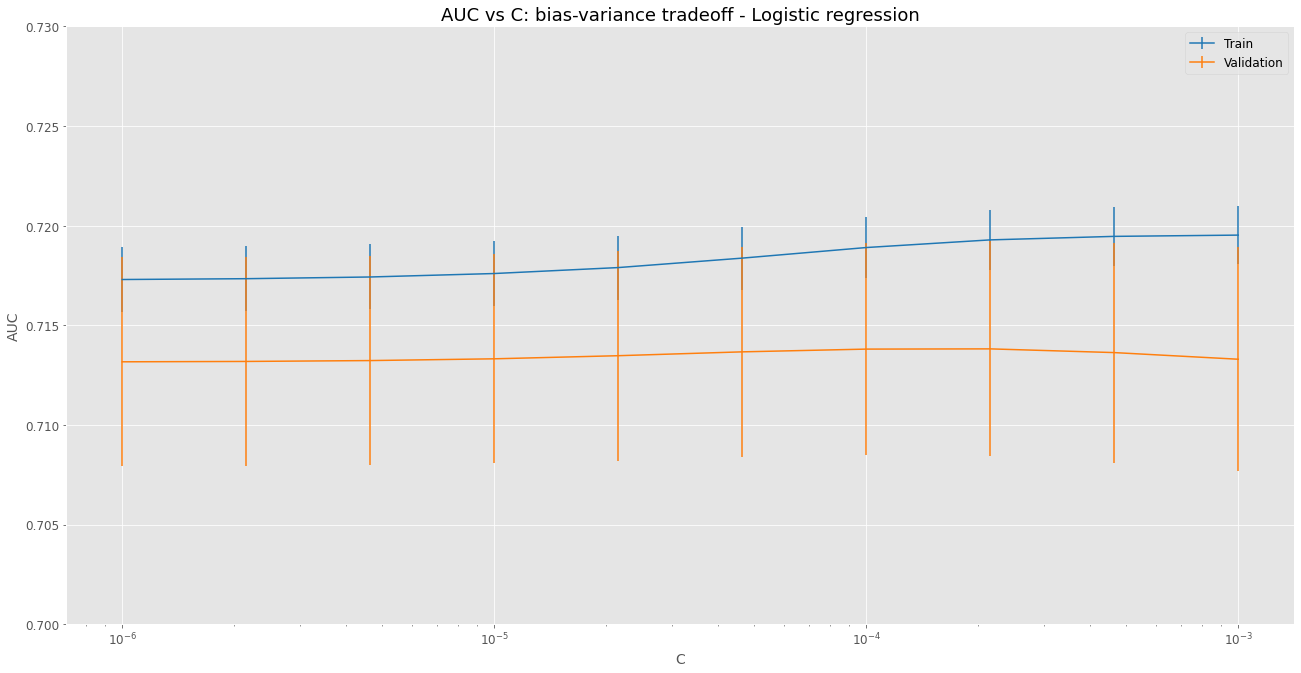

In [32]:
fig, ax = plt.subplots(figsize=(22, 11))

ax.errorbar(
    x=logistic_regression_grid_search.cv_results_["param_C"].data,
    y=logistic_regression_grid_search.cv_results_["mean_train_score"],
    yerr=logistic_regression_grid_search.cv_results_["std_train_score"],
    color=plt.cm.tab10.colors[0],
    label="Train"
)

ax.errorbar(
    x=logistic_regression_grid_search.cv_results_["param_C"].data,
    y=logistic_regression_grid_search.cv_results_["mean_test_score"],
    yerr=logistic_regression_grid_search.cv_results_["std_test_score"],
    color=plt.cm.tab10.colors[1],
    label="Validation"
)

ax.set_ylim(0.7, 0.73)
ax.set_xlabel("C", fontsize=14)
ax.set_ylabel("AUC", fontsize=14)
ax.set_title("AUC vs C: bias-variance tradeoff - Logistic regression", fontsize=18)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xscale("log")


#### 4.2.2 - Decision tree

In [33]:
decision_tree_param_grid = {
    "max_depth":np.arange(1, 11, 1)
}

decision_tree_grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=decision_tree_param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

decision_tree_grid_search.fit(
    X_train_scaled,
    y_train
)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             return_train_score=True, scoring='roc_auc')

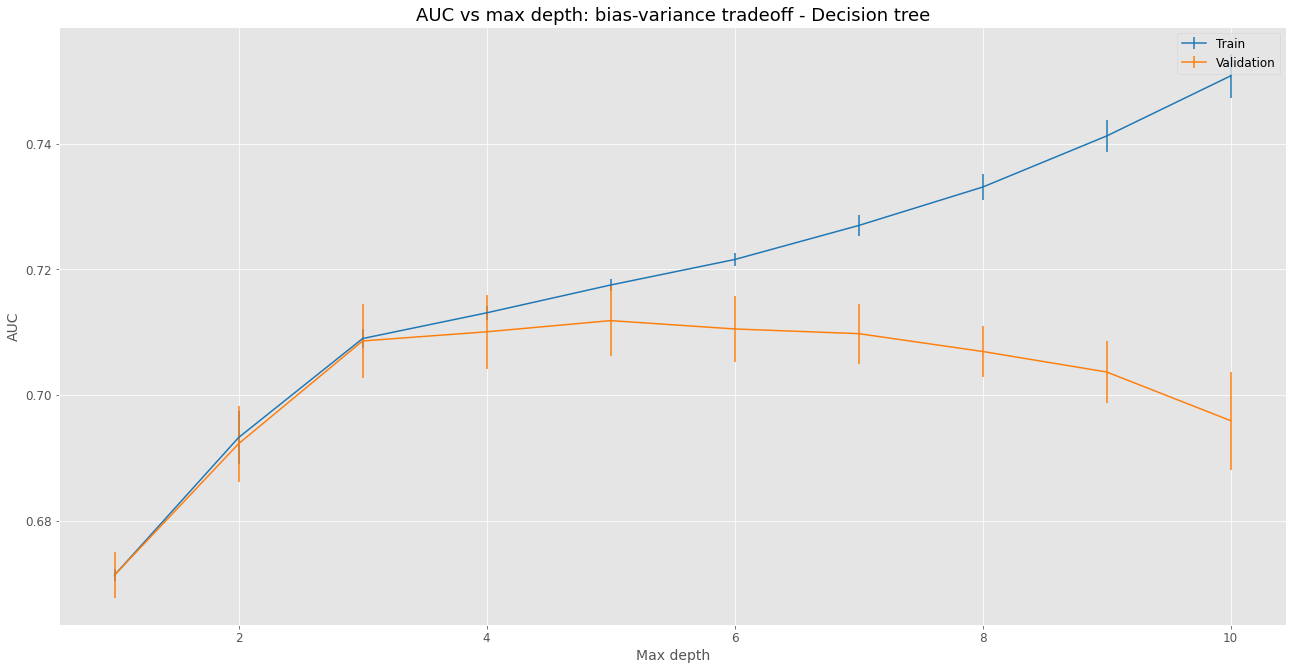

In [34]:
fig, ax = plt.subplots(figsize=(22, 11))

ax.errorbar(
    x=decision_tree_grid_search.cv_results_["param_max_depth"].data,
    y=decision_tree_grid_search.cv_results_["mean_train_score"],
    yerr=decision_tree_grid_search.cv_results_["std_train_score"],
    color=plt.cm.tab10.colors[0],
    label="Train"
)

ax.errorbar(
    x=decision_tree_grid_search.cv_results_["param_max_depth"].data,
    y=decision_tree_grid_search.cv_results_["mean_test_score"],
    yerr=decision_tree_grid_search.cv_results_["std_test_score"],
    color=plt.cm.tab10.colors[1],
    label="Validation"
)

#ax.set_ylim(0.7, 0.73)
ax.set_xlabel("Max depth", fontsize=14)
ax.set_ylabel("AUC", fontsize=14)
ax.set_title("AUC vs max depth: bias-variance tradeoff - Decision tree", fontsize=18)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)


#### 4.2.3 - Random forest

In [35]:
random_forest_param_grid = {
    "n_estimators":np.arange(2, 11,2),
    "max_depth":np.arange(1, 11, 1)
}

random_forest_grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid=random_forest_param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

random_forest_grid_search.fit(
    X_train_scaled,
    y_train
)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 2,  4,  6,  8, 10])},
             return_train_score=True, scoring='roc_auc')

In [36]:
df_random_forest_grid_search_results = (
    pd.DataFrame(random_forest_grid_search.cv_results_["params"])
    .assign(
        mean_train_score = random_forest_grid_search.cv_results_["mean_train_score"],
        std_train_score = random_forest_grid_search.cv_results_["std_train_score"],
        mean_test_score = random_forest_grid_search.cv_results_["mean_test_score"],
        std_test_score = random_forest_grid_search.cv_results_["std_test_score"],
    )
)

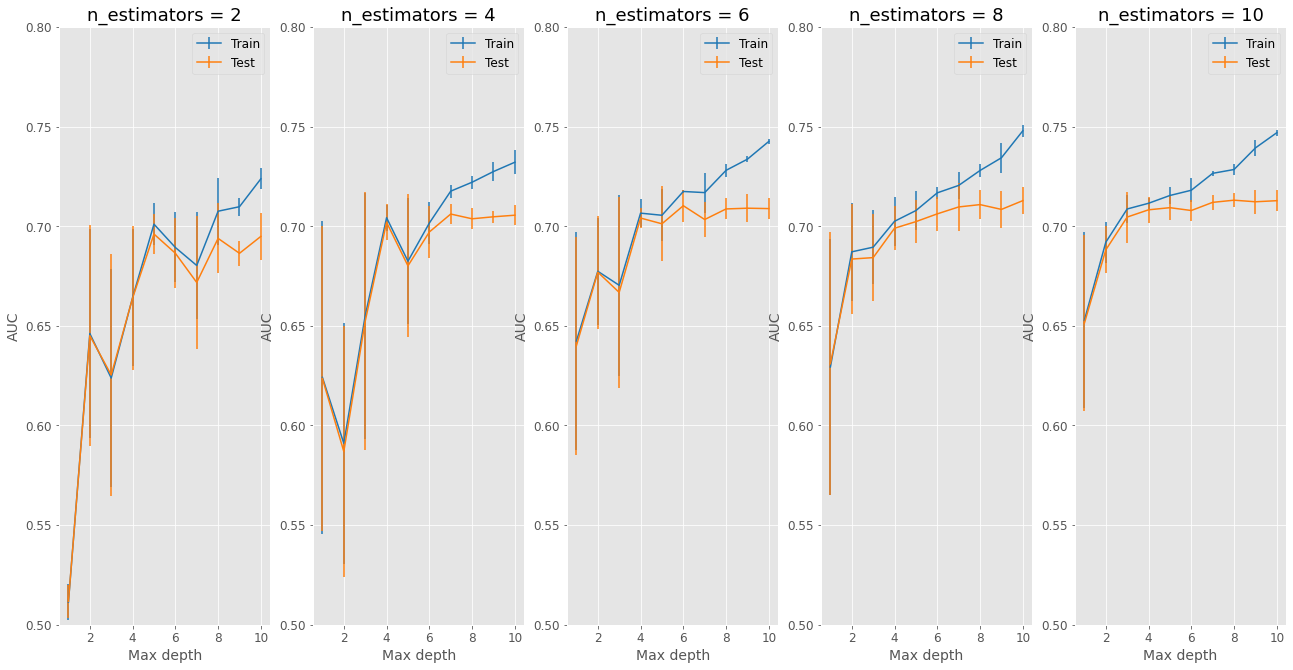

In [37]:
fig, ax = plt.subplots(
    nrows=1, 
    ncols=df_random_forest_grid_search_results["n_estimators"].nunique(), 
    figsize=(22,11)
)

for i, n_estimators in enumerate(df_random_forest_grid_search_results["n_estimators"].unique()):
    df_aux = df_random_forest_grid_search_results.query(f"n_estimators == {n_estimators}")

    ax[i].errorbar(
        x=df_aux["max_depth"],
        y=df_aux["mean_train_score"],
        yerr=df_aux["std_train_score"],
        color=plt.cm.tab10.colors[0],
        label="Train"
    )

    ax[i].errorbar(
        x=df_aux["max_depth"],
        y=df_aux["mean_test_score"],
        yerr=df_aux["std_test_score"],
        color=plt.cm.tab10.colors[1],
        label="Test"
    )
    ax[i].set_ylim(0.5, 0.80)
    ax[i].set_xlabel("Max depth", fontsize=14)
    ax[i].set_ylabel("AUC", fontsize=14)
    ax[i].set_title(f"n_estimators = {n_estimators}", fontsize=18)
    ax[i].legend(fontsize=12)
    ax[i].tick_params(axis='both', which='major', labelsize=12)

### 4.3 - Model comparison

In [38]:
logistic_regression_model = logistic_regression_grid_search.best_estimator_
decision_tree_model = decision_tree_grid_search.best_estimator_
random_forest_model = random_forest_grid_search.best_estimator_

#### 4.3.1 - ROC

In [39]:
(
    fpr_logistic_regression,
    tpr_logistic_regression,
    thr_logistic_regression
) = roc_curve(
    y_test,
    logistic_regression_model.predict_proba(X_test_scaled)[:, 1]
)

In [40]:
(
    fpr_decision_tree,
    tpr_decision_tree,
    thr_decision_tree
) = roc_curve(
    y_test,
    decision_tree_model.predict_proba(X_test_scaled)[:, 1]
)

In [41]:
(
    fpr_random_forest,
    tpr_random_forest,
    thr_random_forest
) = roc_curve(
    y_test,
    random_forest_model.predict_proba(X_test_scaled)[:, 1]
)

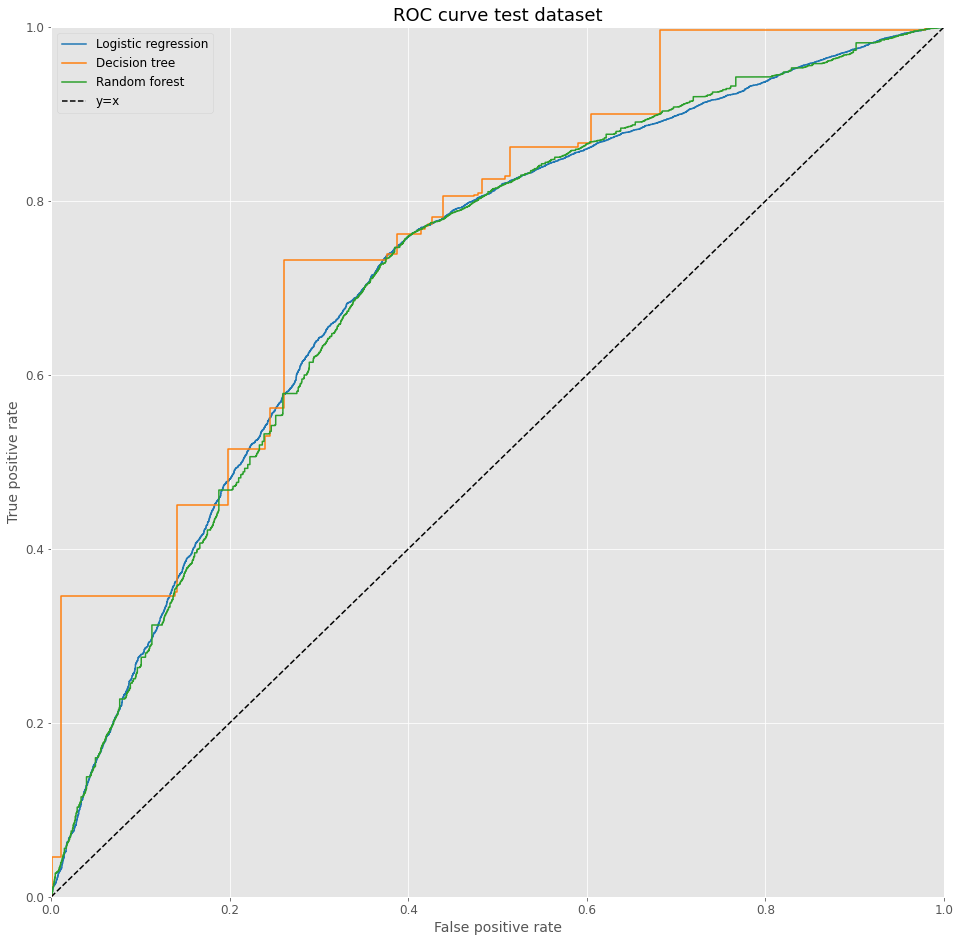

In [42]:
fig, ax = plt.subplots(figsize=(16,16))

ax.step(
    fpr_logistic_regression,
    tpr_logistic_regression,
    color=plt.cm.tab10.colors[0],
    label="Logistic regression"
)

ax.step(
    fpr_decision_tree,
    tpr_decision_tree,
    color=plt.cm.tab10.colors[1],
    label="Decision tree"
)

ax.step(
    fpr_random_forest,
    tpr_random_forest,
    color=plt.cm.tab10.colors[2],
    label="Random forest"
)

ax.plot(
    np.linspace(0,1,100),
    np.linspace(0,1,100),
    color="k",
    label="y=x",
    linestyle="--"
)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("False positive rate", fontsize=14)
ax.set_ylabel("True positive rate", fontsize=14)
ax.set_title("ROC curve test dataset", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12);

#### 4.3.2 - Other metrics

In [43]:
def get_metrics_confidence_interval(X, y, model, N_BOOTSTRAP=1000, alpha=0.05):
    data = pd.DataFrame(X).assign(
        y=y.reset_index(drop=True)
    )
    
    auc_results_list = []
    precision_results_list = []
    recall_results_list = []
    f1_results_list = []
    
    for i in range(0, N_BOOTSTRAP):

        data_sampled = data.sample(frac=1, replace=True)

        X_sampled = data_sampled.drop(columns="y")
        y_sampled = data_sampled["y"]

        y_pred = model.predict(X_sampled)
        y_pred_proba = model.predict_proba(X_sampled)[:, 1]

        auc_results_list.append(
            roc_auc_score(
                y_sampled,
                y_pred_proba
            )
        )

        precision_results_list.append(
            precision_score(
                y_sampled,
                y_pred
            )
        )

        recall_results_list.append(
            recall_score(
                y_sampled,
                y_pred
            )
        )

        f1_results_list.append(
            f1_score(
                y_sampled,
                y_pred
            )
        )

    df_results = pd.DataFrame({
        "auc_interval":[np.quantile(auc_results_list, 1-alpha/2) - np.quantile(auc_results_list, alpha/2)],
        "auc_mean":[np.mean(auc_results_list)],
        "precision_interval":[np.quantile(precision_results_list, 1-alpha/2) - np.quantile(precision_results_list, alpha/2)],
        "precision_mean":[np.mean(precision_results_list)],
        "recall_interval":[np.quantile(recall_results_list, 1-alpha/2) - np.quantile(recall_results_list, alpha/2)],
        "recall_mean":[np.mean(recall_results_list)],
        "f1_interval":[np.quantile(f1_results_list, 1-alpha/2) - np.quantile(f1_results_list, alpha/2)],
        "f1_mean":[np.mean(f1_results_list)]
    })

    return df_results

In [44]:
model_dict = {
    "logistic_regression":logistic_regression_model,
    "decision_tree":decision_tree_model,
    "random_forest":random_forest_model
}

df_list = []

for model_name, model in model_dict.items():
    df_results = get_metrics_confidence_interval(
        X_test_scaled,
        y_test,
        model,
        N_BOOTSTRAP=500,
        alpha=0.05
    ).assign(
        model=model_name
    )
    df_list.append(
        df_results.copy()
    )

df_metrics = pd.concat(
    df_list
).reset_index(drop=True)


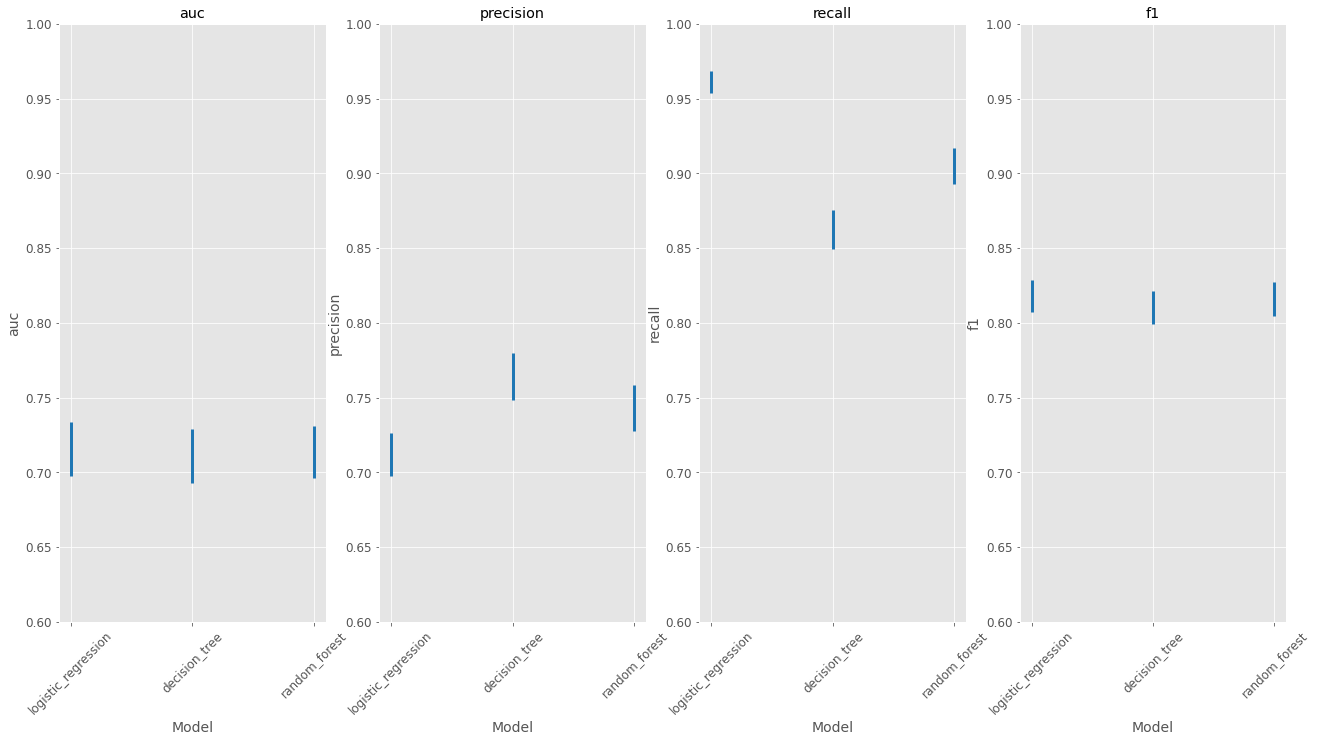

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(22,11))

for i, metric in enumerate(["auc", "precision", "recall", "f1"]):

    ax[i].errorbar(
        x=df_metrics.index,
        y=df_metrics[metric+"_mean"],
        yerr=df_metrics[metric+"_interval"],
        color=plt.cm.tab10.colors[0],
        ls="",
        elinewidth=3
    )

    ax[i].set_xticks(df_metrics.index)
    ax[i].set_xticklabels(df_metrics["model"], rotation=45)
    ax[i].set_xlabel("Model", fontsize=14)
    ax[i].set_ylabel(metric, fontsize=14)
    ax[i].set_ylim(0.6,1)
    ax[i].set_title(metric)
    ax[i].tick_params(axis='both', which='major', labelsize=12)

The image above displays the main metrics for the three developed models, evaluated on the test dataset. In order to get confidence intervals for it, a bootstrap method was used. 

One can notice that the decision tree stands as the most difference performance among the models, when looking at precision and recall. However, given its high performance on precision and low result in recall, the F1 score remains very similar to the other two methods. 

Overall, the choice between the decision forest model and the logistic regression is a difficult one. Given the confidence interval for random forest's recall is smaller than the others, and it results in satisfactory results for precision, F1 and AUC it is reasonable to choose this strategy as the best on among the evaluated ones.

## 5 - Final considerations

For readers who are machine learning aficionados the previous study may seem superficial on some levels:

- 1: No feature engineering was studied, which could improve the model's performance
- 2: The only ensemble method tested was random forest, boosting strategies such as LightGBM or XGBoost could lead to better results
- 3: The hyperparameter tuning could be improved with Optuna or similar algorithms

All of these observations are correct, and I hope to return and discuss it on further articles. However, this is not the main reason I have chosen to dwell on this problem.

There are two main observations I would like to point from this study. Being a data scientist, I believe the current wave on courses and newcomers often fails to help us build a strong critical sense and truly scientific view of our work. Fitting and predicting is often placed as the main target, the holy grail, the essence of our job. However, this previous study can help us discuss some important topics.

With a reasonably simple approach, it was possible to fit the data of interest, leading to acceptable precision results. More specifically, with a precision of nearly 0.7 this model could decide with 70% of precision weather or not to take an action on the trolley dilemma. There are two problems hidden here:

First, the model is merely adjusting the data, it is not solving an ethical dilemma. Given the data available, the chosen algorithms have fitted the samples and learned patters from it, but it is not giving answers beyond the basic one: "Given some information about the person (age, gender, political views...) would he or she take an action on the situation proposed?". I hope you notice how this is closely related to bias in machine learning algorithms. The whole discussion surrounding it often misses the main point: what an algorithm really does. It is just fitting the data, if the data is biased, so would the algorithm. Why? Because the model is not an entity that can "think", it simply mirrors the patterns in the sample.

Second, a very interesting question that could be made about this study surrounds the reasons and causes of the choices. Are men more prone to take action? Does education affect people's decision? I personally see the discussion about causation very incipient on our community. For those who are unaware, machine learning are not causal, they are associative. They make an excellent job on fitting and predicting, but even explainable AI does not deal with the question on "Why someone took the action?" or "Does variable X cause variable Y?", it just focuses on justifying how the model is dealing with the input to generate the output. This is an amazing field, don't get me wrong. Explainable AI is beautiful, important and help us deal with some very troubling questions.

Finally, I hope I can motivate you to look beyond simple ".fit() .predict()". Our job as data scientist involve much more than programming, machine learning or even statistics. We need to cultivate the Science in data science, the ability to look critically at methods and results. This is how we can help advance the barriers of our field, tackle on social problems and use data science (in the words of Alfred Nobel) "for the greatest benefit of mankind".